In [1]:
import sys, os, os.path, time
import argparse
import numpy
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from Net_mModal import Net, NewNet, TransformerEncoder, Transformer, MMTEncoder, LateFusion, videoModel, SuperLateFusion
from util_in_multi_h5_unnorm import *
from util_out import *
from util_f1 import *
from AudioResNet import resnet50

In [2]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    from tensorboardX import SummaryWriter
#from transformers import  AdamW, get_linear_schedule_with_warmup
torch.backends.cudnn.benchmark = True
from torch.optim.lr_scheduler import LambdaLR

In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [4]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.
    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)


# VICTIM MODEL

In [5]:
def mybool(s):
    return s.lower() in ['t', 'true', 'y', 'yes', '1']
parser = argparse.ArgumentParser()
parser.add_argument('--model_type', type = str, default = None, required=True)
parser.add_argument('--embedding_size', type = int, default = 1024) # this is the embedding size after a pooling layer
                                                                    # after a non-pooling layer, the embeddings size will be twice this much
parser.add_argument('--n_conv_layers', type = int, default = 10)
parser.add_argument('--n_trans_layers', type = int, default = 1)
parser.add_argument('--kernel_size', type = str, default = '3')     # 'n' or 'nxm'
parser.add_argument('--n_pool_layers', type = int, default = 5)     # the pooling layers will be inserted uniformly into the conv layers
                                                                    # the should be at least 2 and at most 6 pooling layers
                                                                    # the first two pooling layers will have stride (2,2); later ones will have stride (1,2)
parser.add_argument('--batch_norm', type = mybool, default = True)
parser.add_argument('--dropout', type = float, default = 0.0)
parser.add_argument('--pooling', type = str, default = 'lin', choices = ['max', 'ave', 'lin', 'exp', 'att', 'h-att', 'all'])
parser.add_argument('--batch_size', type = int, default = 250)
parser.add_argument('--ckpt_size', type = int, default = 1000)      # how many batches per checkpoint
parser.add_argument('--optimizer', type = str, default = 'adam', choices = ['adam', 'sgd', 'adamw'])
parser.add_argument('--init_lr', type = float, default = 1e-3)
parser.add_argument('--weight_decay', type = float, default = 0)
parser.add_argument('--beta1', type = float, default = 0.9)
parser.add_argument('--beta2', type = float, default = 0.999)
parser.add_argument('--lr_patience', type = int, default = 3)
parser.add_argument('--lr_factor', type = float, default = 0.8)
parser.add_argument('--max_ckpt', type = int, default = 30)
parser.add_argument('--random_seed', type = int, default = 15213)
parser.add_argument('--additional_outname', type = str, default = '')
parser.add_argument('--continue_from_ckpt', type = str, default = None)
parser.add_argument('--warmup_steps', type = int, default = 1000)
parser.add_argument('--gradient_accumulation', type = int, default = 1)
parser.add_argument('--scheduler', type = str, default = 'reduce', choices = ['reduce', 'warmup-decay'])
parser.add_argument('--addpos', type = mybool, default = False)
parser.add_argument('--transformer_dropout', type = float, default = 0.75)
parser.add_argument('--from_scratch', type = mybool, default = False)
parser.add_argument('--fusion_module', type = int, default = 0) # 0 for early fusion, 1 for mid fusion 1 
###MODEL INPUT PARAMS###
args = parser.parse_args(args=['--model_type=resnet','--init_lr=4e-4','--fusion_module=0','--embedding_size=100','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--gradient_accumulation=3','--max_ckpt=19', '--scheduler=warmup-decay',
                              '--additional_outname=resnet'])



In [6]:
if 'x' not in args.kernel_size:
    args.kernel_size = args.kernel_size + 'x' + args.kernel_size

In [7]:
# Prepare log file and model directory
expid = '%s-embed%d-%dC%dP-kernel%s-%s-drop%.1f-%s-batch%d-ckpt%d-%s-lr%.0e-pat%d-fac%.1f-seed%d-Trans%d-weight-decay%.8f-betas%.3f-%.3f' % (
    args.model_type,
    args.embedding_size,
    args.n_conv_layers,
    args.n_pool_layers,
    args.kernel_size,
    'bn' if args.batch_norm else 'nobn',
    args.dropout,
    args.pooling,
    args.batch_size,
    args.ckpt_size,
    args.optimizer,
    args.init_lr,
    args.lr_patience,
    args.lr_factor,
    args.random_seed,
    args.n_trans_layers,
    args.weight_decay,
    args.beta1, 
    args.beta2
)

In [8]:
expid += args.additional_outname
WORKSPACE = os.path.join('/jet/home/billyli/data_folder/DayLongAudio/workspace/ICASSP2021_tune/', expid)
PRED_PATH = os.path.join(WORKSPACE, 'pred')
if not os.path.exists(PRED_PATH): os.makedirs(PRED_PATH)
EVAL_PATH = os.path.join(WORKSPACE, 'eval')
if not os.path.exists(EVAL_PATH): os.makedirs(EVAL_PATH)
if args.model_type=='TALNet':
    WORKSPACE = '../../workspace/ICASSP2021_tune/MMT-embed1024-10C5P-kernel3x3-bn-drop0.0-att-batch200-ckpt2500-adam-lr4e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999early'
    PRED_PATH = os.path.join(WORKSPACE, 'pred')
    EVAL_PATH = os.path.join(WORKSPACE, 'eval')
    MODEL_FILE = os.path.join(WORKSPACE, 'model', 'checkpoint20.pt')
    PRED_FILE = os.path.join(PRED_PATH, 'checkpoint20.mat')
    EVAL_FILE = os.path.join(EVAL_PATH, 'checkpoint20.txt')
else:
    MODEL_FILE = os.path.join(WORKSPACE, 'model','checkpoint%d.pt' % args.max_ckpt)
    PRED_FILE = os.path.join(PRED_PATH, 'checkpoint%d.mat' % args.max_ckpt)
    EVAL_FILE = os.path.join(EVAL_PATH, 'checkpoint%d.txt' % args.max_ckpt)

In [9]:
args.kernel_size

'3x3'

In [10]:
print(args.model_type)
print(MODEL_FILE)

resnet
/jet/home/billyli/data_folder/DayLongAudio/workspace/ICASSP2021_tune/resnet-embed100-10C5P-kernel3x3-bn-drop0.0-att-batch100-ckpt2500-adam-lr4e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999resnet/model/checkpoint19.pt


In [11]:
# Load model
args.kernel_size = tuple(int(x) for x in args.kernel_size.split('x'))
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = Net(args).cuda()
elif args.model_type == 'TAL-trans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
else:
    print ('model type not recognized')
    exit(0)


In [12]:
if args.optimizer == 'sgd':
    optimizer = SGD(model.parameters(), lr = args.init_lr, momentum = 0.9, nesterov = True)
elif args.optimizer == 'adam':
    optimizer = Adam(model.parameters(), lr = args.init_lr, betas=(args.beta1, args.beta2), weight_decay=args.weight_decay)
elif args.optimizer == 'adamw':
    optimizer = AdamW(model.parameters(), lr = args.init_lr, betas=(args.beta1, args.beta2), weight_decay=args.weight_decay)
if args.scheduler == 'reduce':
    scheduler = ReduceLROnPlateau(optimizer, mode = 'max', factor = args.lr_factor, patience = args.lr_patience) if args.lr_factor < 1.0 else None
elif args.scheduler == 'warmup-decay':
    t_total = args.ckpt_size * args.max_ckpt / args.gradient_accumulation
#     scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total) Deprecated API style
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps = t_total)

else:
    print ('scheduler type not recognized')
    exit(0)

In [13]:
prev_ckpt = torch.load(MODEL_FILE)
start_ckpt = prev_ckpt['epoch']
scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
model.load_state_dict(prev_ckpt['model'])
optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
gas_valid_x1, gas_valid_x2, gas_valid_y, gas_eval_hashes = multi_bulk_load('GAS_valid')
gas_eval_x1, gas_eval_x2, gas_eval_y, gas_eval_hashes = multi_bulk_load('GAS_eval')

# data pipeline

In [27]:
gas_eval_x1, gas_eval_x2, gas_eval_y, gas_eval_hashes = multi_bulk_load('GAS_eval')

In [28]:
gas_eval_y.shape

(20098, 527)

In [29]:
print(gas_eval_y[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [15]:
gas_eval_global_prob_multi = model.predict(gas_eval_x1, verbose=False)

In [16]:
print(gas_eval_global_prob_multi.shape)

(20098, 527)


In [17]:
print('Performance on Google Audio Set:')
print("   CLASS ||    AP |   AUC |    d' ")
FORMAT  = ' %00007s || %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS ||    AP |   AUC |    d' 
---------++-------+-------+-------


In [18]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))


0.3368552010314255 0.9552638144333935 2.4015998530474723
 Average || 0.337 | 0.955 | 2.402 
---------++-------+-------+-------
       0 || 0.720 | 0.911 | 1.901 
       1 || 0.068 | 0.811 | 1.249 
       2 || 0.111 | 0.929 | 2.080 
       3 || 0.365 | 0.960 | 2.470 
       4 || 0.212 | 0.971 | 2.672 
       5 || 0.054 | 0.938 | 2.181 
       6 || 0.410 | 0.994 | 3.588 
       7 || 0.384 | 0.978 | 2.843 
       8 || 0.133 | 0.929 | 2.081 
       9 || 0.060 | 0.911 | 1.902 
      10 || 0.105 | 0.961 | 2.494 
      11 || 0.214 | 0.978 | 2.847 
      12 || 0.811 | 0.999 | 4.428 
      13 || 0.462 | 0.991 | 3.322 
      14 || 0.201 | 0.973 | 2.729 
      15 || 0.662 | 0.986 | 3.117 
      16 || 0.372 | 0.976 | 2.785 
      17 || 0.545 | 0.977 | 2.815 
      18 || 0.232 | 0.981 | 2.931 
      19 || 0.224 | 0.969 | 2.635 
      20 || 0.329 | 0.987 | 3.145 
      21 || 0.143 | 0.973 | 2.736 
      22 || 0.361 | 0.983 | 2.994 
      23 || 0.409 | 0.984 | 3.035 
      24 || 0.192 | 0.963 | 2.530

In [19]:
import matplotlib.pyplot as plt


<Figure size 28800x7200 with 0 Axes>

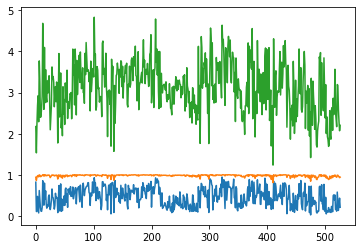

<Figure size 28800x7200 with 0 Axes>

In [24]:
plt.plot(classwise)
plt.figure(figsize=(400,100)) 


# Adversarial Routine

In [ ]:
for batch in range(1, args.ckpt_size + 1):
        x, y = next(train_gen)
        global_prob = model(x)[0]
        global_prob.clamp_(min = 1e-7, max = 1 - 1e-7)
        loss = criterion(global_prob, y)
        if args.gradient_accumulation > 1:
            loss = loss / args.gradient_accumulation
        #if n_gpu > 1:
        #    loss = loss.mean()
        train_loss += loss.item()
        if numpy.isnan(train_loss) or numpy.isinf(train_loss): break
        loss.backward()
        global_step += 1
        if global_step % args.gradient_accumulation == 0:
            optimizer.step()
            if args.scheduler == 'warmup-decay':
                scheduler.step() 
            optimizer.zero_grad()
        if batch % 500 == 0:
            sys.stderr.write('Checkpoint %d, Batch %d / %d, avg train loss = %f\r' % \
                            (checkpoint, batch, args.ckpt_size, train_loss / batch))
            tb_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], global_step)
            tb_writer.add_scalar('loss', train_loss / batch, global_step)
            
        del x, y, global_prob, loss         # This line and next line: to save GPU memory
        torch.cuda.empty_cache()            # I don't know if they're useful or not
    train_loss /= args.ckpt_size


In [ ]:
def train(opt, model, adv_jam, trainloader, max_batches = 100):
    model.eval()
        
    batches = 0
    total = 0
    error = 0
    loss_ = 0.
    torch.manual_seed(0)

    for X_batch, y_batch in trainloader:
        # forward pass
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        # plot(X_batch[0], y_batch[0])
        output = model(adv_jam(X))
        opt.zero_grad()
        neg_loss = -nn.CrossEntropyLoss()(output, y)

        neg_loss.backward()
        opt.step()



        # Evaluate performance
        adv_out = model(X_adv)
        adv_prediction = sigmoid(adv_out.squeeze().cpu().detach())>0.5
        adv_accuracy = (adv_prediction.numpy()==y_batch.cpu().numpy()).mean()
        print("Accuracy = {0}".format(adv_accuracy))
                # project into feasible region
        adv.jam.param1.clamp_(0,1)
        adv.jam.param2.clamp_(1, 40)
        adv.jam.param3.clamp_(0,224)
        total += X.shape[0]
        error += (output.max(1)[1] != y).sum().item()
        loss_ += nn.CrossEntropyLoss(size_average=False)(output, y).item()
            batches += 1
            if batches > max_batches:
                break

        return error / total, loss_ / total

In [1]:
def projected_gradient_descent(model, x, y, num_steps = 20, step_size = 0.1, step_norm=2, eps = 10, eps_norm=2,
                               clamp=(x_min, x_max), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True)#.to(x.device)
    N, T, V = x.shape
    targeted = y_target is not None
    num_channels = x.shape[1]
    criterion = nn.BCELoss()

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)
        
        out = model(_x_adv) # N x T x 1
        out_flatten = out.reshape(-1) 
        y_flatten = y.reshape(-1)
        loss = criterion(out_flatten, y_flatten)
        
        #prediction = model(_x_adv)
        #loss = criterion(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # The grad is normalized here.
                #gradients = _x_adv.grad 
                # Only normalize w.r.t. to feats at a timestep
                gradients = _x_adv.grad/_x_adv.grad.norm(step_norm, dim=-1).view(-1, T, 1)
                gradients *= step_size
                
            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], T, -1).norm(eps_norm, dim=-1)
            scaling_factor[mask] = eps
            #print(scaling_factor.shape)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()

NameError: name 'x_min' is not defined